This notebook will take the results of different runs of COMPAS and plot those difference

In [2]:
# let's import things
import h5py as h5 
import pandas as pd
from astropy.table import Table
from astropy import units as u
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text.latex', preamble=r'\usepackage{textgreek}')
plt.rc('font', family='serif')
import sys
import os
from scipy import stats
import seaborn as sns

# Add the subdir to sys.path
sys.path.append('/home/jovyan/home/research_work/useful_py_scripts/')

# Now you can import the module
import useful_fncs 

### 1) Get the results of the merger rate at z = 0 for $\alpha_{CE}$ of 0.25, 0.5, 0.75, 1, 2

In [3]:
# let's make a function where we can get these results quickly 

def merger_rate_z0_result(pathToweights_H5):

    # we first need to gather the information for the file of interest
    # reading in the HDF5 file
    Data_weights = h5.File(pathToweights_H5,"r")

    # let's gather the system parameters group 
    SP_WD_data = pd.DataFrame() # making a pandas dataframe

    for key in Data_weights["BSE_Double_Compact_Objects"].keys(): #looping through the "keys" or paramters in BSE_System_Parameters

        SP_WD_data[key] = Data_weights["BSE_Double_Compact_Objects"][key][()] # adding these columns to the dataframe

    # Rates info directly taking out the 
    merger_SEED = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['SEED'][()]
    rates_DCO = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['merger_rate'][()]
    rates_z0_DCO = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['merger_rate_z0'][()]
    DCO_mask = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['DCOmask'][()]
    redshifts = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['redshifts'][()]
    # rates_info = Data_weights["Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048"]

    Data_weights.close()



    #let's next make sure that we are selecting for WD+WD systems
    SP_DCO_DATA = SP_WD_data[DCO_mask]

    # let's make sure that at least one of these white dwarfs are COWD
    HeWD_bool,COWD_bool,ONeWD_bool,HeCOWD_bool,HeONeWD_bool,COHeWD_bool,COONeWD_bool,ONeHeWD_bool,ONeCOWD_bool = useful_fncs.WD_BINARY_BOOLS(SP_DCO_DATA)
    carbon_oxygen_bool = np.logical_or(ONeCOWD_bool,np.logical_or(COONeWD_bool,np.logical_or(COHeWD_bool,np.logical_or(COWD_bool,HeCOWD_bool))))
    SP_COWD_DATA = SP_DCO_DATA[carbon_oxygen_bool]



    # let's now sort our data into the mass regimes we care about
    # let's add the flags for specific calssifications of SN Ia

    SN_Ia_HVS,two_star_SNIA,Champagne_Supernova = useful_fncs.check_if_SNIA(SP_COWD_DATA['Mass(1)'],SP_COWD_DATA['Mass(2)'])
    # adding the flags to the dataframe
    SP_COWD_DATA = SP_COWD_DATA.assign(SN_Ia_HVS = SN_Ia_HVS)
    SP_COWD_DATA = SP_COWD_DATA.assign(two_star_SNIA = two_star_SNIA)
    SP_COWD_DATA = SP_COWD_DATA.assign(Champagne_Supernova = Champagne_Supernova)

    # let's now gather the merger rate at redshift zero
    WDWD_merger_rate_Z0 = rates_z0_DCO[carbon_oxygen_bool]
    SP_COWD_DATA = SP_COWD_DATA.assign(WDWD_merger_rate_Z0 = WDWD_merger_rate_Z0)

    # let's now get the values of these merger rates for all of the systems that fall within specific regimes
    SN_Ia_HVS_z0_rate = np.sum(SP_COWD_DATA['WDWD_merger_rate_Z0'][SP_COWD_DATA['SN_Ia_HVS']== True])
    two_star_SNIA_z0_rate = np.sum(SP_COWD_DATA['WDWD_merger_rate_Z0'][SP_COWD_DATA['two_star_SNIA']== True])
    Champagne_Supernova_z0_rate = np.sum(SP_COWD_DATA['WDWD_merger_rate_Z0'][SP_COWD_DATA['Champagne_Supernova']== True])

    return([SN_Ia_HVS_z0_rate,two_star_SNIA_z0_rate,Champagne_Supernova_z0_rate])

In [19]:
merger_rates_z0_CEalpha025 = merger_rate_z0_result('/home/jovyan/home/copy_h5_files/v03.08.01/CEalpha025/N1e6_MassiveWDWD_NSNS_CEalpha025_fbinNone.h5')
merger_rates_z0_CEalpha05 = merger_rate_z0_result('/home/jovyan/home/copy_h5_files/v03.08.01/CEalpha05/N1e6_MassiveWDWD_NSNS_CEalpha05_fbinNone.h5')
merger_rates_z0_CEalpha075 = merger_rate_z0_result('/home/jovyan/home/copy_h5_files/v03.08.01/CEalpha075/N1e6_MassiveWDWD_NSNS_CEalpha075_fbinNone.h5')
merger_rates_z0_CEalpha1 = merger_rate_z0_result('/home/jovyan/home/copy_h5_files/v03.08.01/CEalpha1/N1e6_MassiveWDWD_NSNS_CEalpha1_fbinNone.h5')
merger_rates_z0_CEalpha2 = merger_rate_z0_result('/home/jovyan/home/copy_h5_files/v03.08.01/N1e6_MassiveWDWD_NSNS_CEalpha2/N1e6_MassiveWDWD_NSNS_CEalpha2_fbinNone/N1e6_MassiveWDWD_NSNS_CEalpha2_fbinNone.h5')


### 2) Let's now define the different variations we have

In [20]:
variations_compas = [0.25,0.5,0.75,1.0,2.0]
rates_SN_Ia_HVS  =[merger_rates_z0_CEalpha025[0],merger_rates_z0_CEalpha05[0],merger_rates_z0_CEalpha075[0],merger_rates_z0_CEalpha1[0],merger_rates_z0_CEalpha2[0]]
rates_two_star_SNIA  =[merger_rates_z0_CEalpha025[1],merger_rates_z0_CEalpha05[1],merger_rates_z0_CEalpha075[1],merger_rates_z0_CEalpha1[1],merger_rates_z0_CEalpha2[1]]
rates_Champagne_Supernova  =[merger_rates_z0_CEalpha025[2],merger_rates_z0_CEalpha05[2],merger_rates_z0_CEalpha075[2],merger_rates_z0_CEalpha1[2],merger_rates_z0_CEalpha2[2]]

### 3) Let's now make the plot!

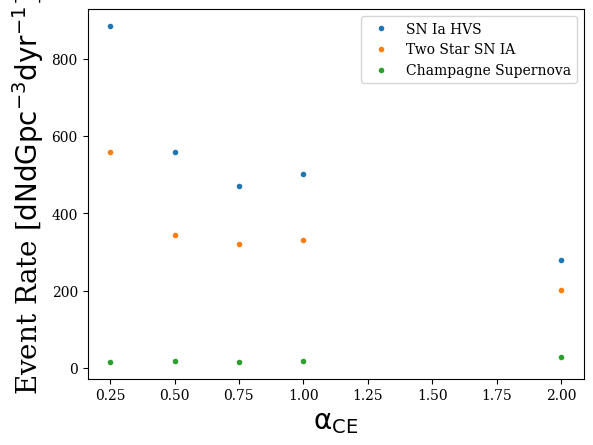

In [23]:
# we want all of the of SN to have the same color marker

plt.plot(variations_compas,rates_SN_Ia_HVS,'.', label='SN Ia HVS' )
plt.plot(variations_compas,rates_two_star_SNIA,'.',label='Two Star SN IA')
plt.plot(variations_compas,rates_Champagne_Supernova,'.',label='Champagne Supernova')

# axes labels 
plt.ylabel(r"Event Rate [$\mathrm{dNdGpc^{-3}dyr^{-1}}$]",fontsize=20)
plt.xlabel(r"$\mathrm{\alpha_{CE}}$", fontsize = 20)
plt.legend()